# Fitting Gaussian Process Dataset

## Import libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from create_data import square_exponential_kernel, gaussian_process
from DKL import DKLModel, SimpleNN
from GP import optimize_hyperparameters, fit_gaussian_process
from NN import NN
import torch
import torch.nn as nn
import gpytorch

## Create a dataset

In [2]:
### Simulate Data
np.random.seed(42)
torch.manual_seed(42)

# Parameters
N = 400
x_min, x_max = 0, 10

#  Uniform Grid
X = np.linspace(x_min, x_max, N)

# Kernel and mean functions
length_scale = 1.0
sigma_f = 1.0
sigma_n = 0.1
kernel_func = lambda x1, x2: square_exponential_kernel(x1, x2, length_scale, sigma_f, sigma_n)
mean_func = lambda x: np.zeros(x.shape[0])

# Simulate GP
Y = gaussian_process(X, mean_func, kernel_func)

### Split Data
X_train, _, Y_train, _ = train_test_split(X, Y, test_size=0.5)

In [3]:
# Prepare Tensors
X_train_torch = torch.tensor(X_train).float().unsqueeze(-1)
Y_train_torch = torch.tensor(Y_train).float().squeeze(-1)
X_torch = torch.tensor(X).float().unsqueeze(-1)

# Sort X for Plotting
idx = np.argsort(X)
X_sorted = X[idx]

# Neural Network

In [4]:
# Train NN
NN_model = NN()
NN_model.fit(X_train_torch, Y_train_torch)

# Predict
Y_pred_NN = NN_model.predict(X_torch).detach()

# Convert to NumPy for Plotting
Y_pred_NN = Y_pred_NN.numpy().squeeze()

# Sort Y_pred_NN for Plotting
Y_pred_NN = Y_pred_NN[idx]

Epoch 1/100: Train Loss = 1.2943
Epoch 2/100: Train Loss = 0.5369
Epoch 3/100: Train Loss = 0.4583
Epoch 4/100: Train Loss = 0.4339
Epoch 5/100: Train Loss = 0.5292
Epoch 6/100: Train Loss = 0.4556
Epoch 7/100: Train Loss = 0.5670
Epoch 8/100: Train Loss = 0.5019
Epoch 9/100: Train Loss = 0.4603
Epoch 10/100: Train Loss = 0.5845
Epoch 11/100: Train Loss = 0.5164
Epoch 12/100: Train Loss = 0.5855
Epoch 13/100: Train Loss = 0.4612
Epoch 14/100: Train Loss = 0.5502
Epoch 15/100: Train Loss = 0.5228
Epoch 16/100: Train Loss = 0.4455
Epoch 17/100: Train Loss = 0.5810
Epoch 18/100: Train Loss = 0.4236
Epoch 19/100: Train Loss = 0.4676
Epoch 20/100: Train Loss = 0.4927
Epoch 21/100: Train Loss = 0.4751
Epoch 22/100: Train Loss = 0.5083
Epoch 23/100: Train Loss = 0.4137
Epoch 24/100: Train Loss = 0.4175
Epoch 25/100: Train Loss = 0.5398
Epoch 26/100: Train Loss = 0.4498
Epoch 27/100: Train Loss = 0.4500
Epoch 28/100: Train Loss = 0.4644
Epoch 29/100: Train Loss = 0.4406
Epoch 30/100: Train Los

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


# Gaussian Process

In [5]:
# Optimize Hyperparameters
length_scale_opt, sigma_f_opt, sigma_n_opt = optimize_hyperparameters(X_train, Y_train)
kernel_func_gp = lambda x1, x2: square_exponential_kernel(x1, x2, length_scale_opt, sigma_f_opt, sigma_n_opt)
print(f"Optimized length_scale: {length_scale_opt:.3f}, sigma_f: {sigma_f_opt:.3f}, sigma_n: {sigma_n_opt:.3f}")

mean_post, cov_post = fit_gaussian_process(X_train, Y_train, X, kernel_func_gp)

# Sort for Plotting
mean_post_sorted = mean_post[idx]
cov_post_sorted = cov_post[np.ix_(idx, idx)]


/Users/pierrejoly/Desktop/Book/Projet Option/Code/GP-Dataset/GP.py:16: RuntimeWarning: divide by zero encountered in log
  log_likelihood -= 0.5 * np.log(np.linalg.det(K))
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Optimized length_scale: 1.000, sigma_f: 1.000, sigma_n: 0.100


# Deep Kernel Learning

In [6]:
# Initialize NN
feature_extractor = SimpleNN()
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = DKLModel(X_train_torch, Y_train_torch, likelihood, feature_extractor)

# Train DKL
model.fit(X_train_torch, Y_train_torch)

# Predict
model.eval()
likelihood.eval()

with torch.no_grad():
    Y_pred_dkl = likelihood(model(X_torch))

# Get Predictions
mean = Y_pred_dkl.mean.detach().numpy()
lower, upper = Y_pred_dkl.confidence_region()
lower = lower.detach().numpy()
upper = upper.detach().numpy()

# Sort
mean = mean[idx]
lower = lower[idx]
upper = upper[idx]

Epoch 1/100: Train Loss = 0.9639
Epoch 2/100: Train Loss = 0.8623
Epoch 3/100: Train Loss = 0.8250
Epoch 4/100: Train Loss = 0.8227
Epoch 5/100: Train Loss = 0.8245
Epoch 6/100: Train Loss = 0.8256
Epoch 7/100: Train Loss = 0.8253
Epoch 8/100: Train Loss = 0.8235
Epoch 9/100: Train Loss = 0.8203
Epoch 10/100: Train Loss = 0.8159
Epoch 11/100: Train Loss = 0.8104
Epoch 12/100: Train Loss = 0.8039
Epoch 13/100: Train Loss = 0.7965
Epoch 14/100: Train Loss = 0.7886
Epoch 15/100: Train Loss = 0.7810
Epoch 16/100: Train Loss = 0.7759
Epoch 17/100: Train Loss = 0.7776
Epoch 18/100: Train Loss = 0.7757
Epoch 19/100: Train Loss = 0.7679
Epoch 20/100: Train Loss = 0.7613
Epoch 21/100: Train Loss = 0.7575
Epoch 22/100: Train Loss = 0.7548
Epoch 23/100: Train Loss = 0.7522
Epoch 24/100: Train Loss = 0.7492
Epoch 25/100: Train Loss = 0.7457
Epoch 26/100: Train Loss = 0.7416
Epoch 27/100: Train Loss = 0.7371
Epoch 28/100: Train Loss = 0.7325
Epoch 29/100: Train Loss = 0.7281
Epoch 30/100: Train Los

# Plotting

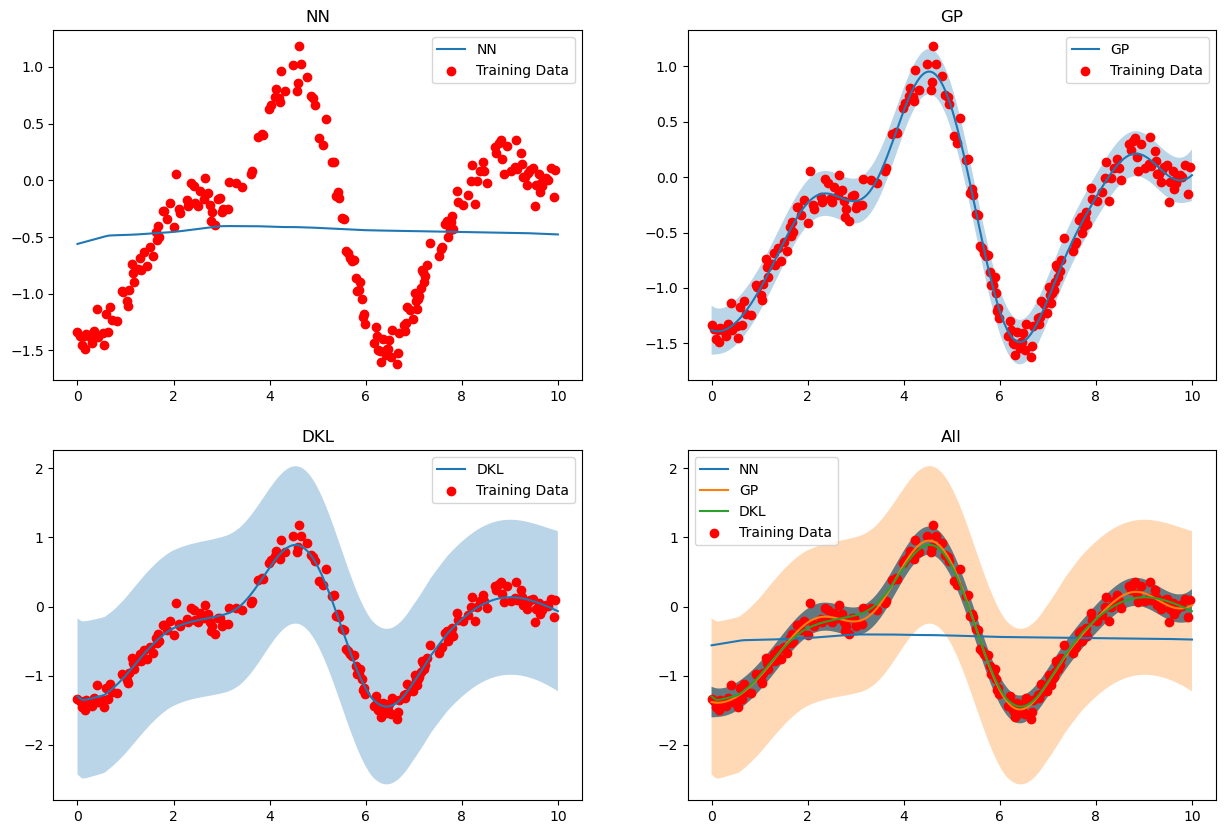

In [7]:
ax, fig = plt.subplots(2, 2, figsize=(15, 10))

# NN
fig[0, 0].plot(X_sorted, Y_pred_NN, label="NN")
fig[0, 0].scatter(X_train, Y_train, color='red', label="Training Data")
fig[0, 0].set_title("NN")
fig[0, 0].legend()

# GP
fig[0, 1].plot(X_sorted, mean_post_sorted, label="GP")
fig[0, 1].fill_between(X_sorted, mean_post_sorted - 1.96 * np.sqrt(np.diag(cov_post_sorted)),
                       mean_post_sorted + 1.96 * np.sqrt(np.diag(cov_post_sorted)), alpha=0.3)
fig[0, 1].scatter(X_train, Y_train, color='red', label="Training Data")
fig[0, 1].set_title("GP")
fig[0, 1].legend()

# DKL
fig[1, 0].plot(X_sorted, mean, label="DKL")
fig[1, 0].fill_between(X_sorted, lower, upper, alpha=0.3)
fig[1, 0].scatter(X_train, Y_train, color='red', label="Training Data")
fig[1, 0].set_title("DKL")
fig[1, 0].legend()

# All
fig[1, 1].plot(X_sorted, Y_pred_NN, label="NN")
fig[1, 1].plot(X_sorted, mean_post_sorted, label="GP")
fig[1, 1].fill_between(X_sorted, mean_post_sorted - 1.96 * np.sqrt(np.diag(cov_post_sorted)),
                       mean_post_sorted + 1.96 * np.sqrt(np.diag(cov_post_sorted)), alpha=1.0)
fig[1, 1].plot(X_sorted, mean, label="DKL")
fig[1, 1].fill_between(X_sorted, lower, upper, alpha=0.3)
fig[1, 1].scatter(X_train, Y_train, color='red', label="Training Data")
fig[1, 1].set_title("All")
fig[1, 1].legend()